In [2]:
import tensorflow as tf
import os
import cv2
import random
import numpy as np
from tensorflow.keras import optimizers, layers, models
from matplotlib import pyplot as plt

## Data Prep

In [3]:
image_dir = "images/lattice_points"
train_files = [[], []]

for file in os.listdir(os.path.join(image_dir, "no")):
    if file.endswith(".jpg"):
        train_files[0].append(os.path.join(image_dir, "no", file))

for file in os.listdir(os.path.join(image_dir, "yes")):
    if file.endswith(".jpg"):
        train_files[1].append(os.path.join(image_dir, "yes", file))

In [4]:
all_images = []
all_labels = []

for i in range(2):
    for file in train_files[i]:
        img = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
        
        img = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU)[1]
        img = cv2.Canny(img, 0, 255)
        
        img = img.astype(np.float32) / 255.0
        
        all_images.append(img)
        
        label = [0, 0]
        label[i] = 1
        all_labels.append(label)

all_images = np.array(all_images)[..., np.newaxis]
all_labels = np.array(all_labels)

In [5]:
print(all_images.shape, all_labels.shape)
print(all_images.max())
print(all_labels[0])

(5366, 21, 21, 1) (5366, 2)
1.0
[1 0]


[0 1]


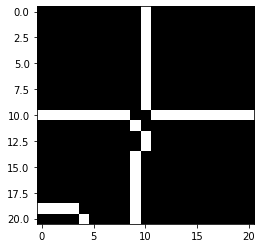

In [6]:
plt.figure()
plt.imshow(all_images[-1][:, :, 0], cmap="gray")
print(all_labels[-1])

In [11]:
train_images = []
train_labels = []
valid_images = []
valid_labels = []

train_indices = random.sample(range(len(all_images)), int(len(all_images) * 0.8))

for i in range(len(all_images)):
    if i in train_indices:
        train_images.append(all_images[i])
        train_labels.append(all_labels[i])
    else:
        valid_images.append(all_images[i])
        valid_labels.append(all_labels[i])

train_images = np.array(train_images)
train_labels = np.array(train_labels)
valid_images = np.array(valid_images)
valid_labels = np.array(valid_labels)

In [12]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True,
    width_shift_range=4,
    height_shift_range=4)

## Initialize Network

In [7]:
model = models.Sequential()
model.add(layers.Dense(441, input_shape=(21, 21, 1)))

for i in range(2):
    for j in [3, 2, 1]:
        model.add(layers.Conv2D(16, j, activation="elu"))
    model.add(layers.MaxPooling2D(pool_size=(2, 2)))
    model.add(layers.BatchNormalization())
    
model.add(layers.Dense(128, activation="elu"))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())

model.add(layers.Dense(2, activation="softmax"))
model.compile(optimizers.RMSprop(lr=1e-3), loss="categorical_crossentropy", metrics=["categorical_accuracy"])

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 21, 21, 441)       882       
_________________________________________________________________
conv2d (Conv2D)              (None, 19, 19, 16)        63520     
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 18, 16)        1040      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 16)        272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 9, 9, 16)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 16)          64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 16)          2

In [9]:
def generate_data(train_images, train_labels, batch_size):
    gen = datagen.flow(train_images, train_labels, batch_size=batch_size)
    while True:
        x, y = gen.next()
        yield x, y

In [13]:
batch_size = 50
epochs = 100

history = model.fit_generator(generate_data(train_images, train_labels, batch_size=batch_size),
                              steps_per_epoch=train_images.shape[0] // batch_size,
                              epochs=epochs, validation_data = (valid_images, valid_labels))

W0327 14:17:01.142286 4537986496 deprecation.py:323] From <ipython-input-13-a4605e9f4332>:6: Model.fit_generator (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
Please use Model.fit, which supports generators.
W0327 14:17:01.161406 4537986496 data_adapter.py:1091] sample_weight modes were coerced from
  ...
    to  
  ['...']


Train for 85 steps, validate on 1074 samples
Epoch 1/100
85/85 [==============================] - 14s 168ms/step - loss: 0.4419 - categorical_accuracy: 0.7849 - val_loss: 0.4411 - val_categorical_accuracy: 0.8901
Epoch 2/100
85/85 [==============================] - 14s 160ms/step - loss: 0.3129 - categorical_accuracy: 0.8659 - val_loss: 0.2574 - val_categorical_accuracy: 0.9534
Epoch 3/100
85/85 [==============================] - 13s 151ms/step - loss: 0.2501 - categorical_accuracy: 0.8977 - val_loss: 0.1211 - val_categorical_accuracy: 0.9646
Epoch 4/100
85/85 [==============================] - 13s 150ms/step - loss: 0.2063 - categorical_accuracy: 0.9229 - val_loss: 0.0775 - val_categorical_accuracy: 0.9767
Epoch 5/100
85/85 [==============================] - 13s 150ms/step - loss: 0.1770 - categorical_accuracy: 0.9347 - val_loss: 0.0670 - val_categorical_accuracy: 0.9823
Epoch 6/100
85/85 [==============================] - 13s 150ms/step - loss: 0.1685 - categorical_accuracy: 0.9415 -

85/85 [==============================] - 13s 151ms/step - loss: 0.0933 - categorical_accuracy: 0.9734 - val_loss: 0.0632 - val_categorical_accuracy: 0.9842
Epoch 50/100
85/85 [==============================] - 13s 150ms/step - loss: 0.0971 - categorical_accuracy: 0.9715 - val_loss: 0.0625 - val_categorical_accuracy: 0.9870
Epoch 51/100
85/85 [==============================] - 13s 151ms/step - loss: 0.0928 - categorical_accuracy: 0.9724 - val_loss: 0.1067 - val_categorical_accuracy: 0.9730
Epoch 52/100
85/85 [==============================] - 13s 150ms/step - loss: 0.0945 - categorical_accuracy: 0.9743 - val_loss: 0.0732 - val_categorical_accuracy: 0.9767
Epoch 53/100
85/85 [==============================] - 13s 150ms/step - loss: 0.0857 - categorical_accuracy: 0.9736 - val_loss: 0.0701 - val_categorical_accuracy: 0.9823
Epoch 54/100
85/85 [==============================] - 13s 150ms/step - loss: 0.0889 - categorical_accuracy: 0.9741 - val_loss: 0.0614 - val_categorical_accuracy: 0.9860

85/85 [==============================] - 14s 161ms/step - loss: 0.0809 - categorical_accuracy: 0.9778 - val_loss: 0.0546 - val_categorical_accuracy: 0.9879
Epoch 98/100
85/85 [==============================] - 14s 161ms/step - loss: 0.0843 - categorical_accuracy: 0.9800 - val_loss: 0.0518 - val_categorical_accuracy: 0.9860
Epoch 99/100
85/85 [==============================] - 14s 162ms/step - loss: 0.0795 - categorical_accuracy: 0.9795 - val_loss: 0.0534 - val_categorical_accuracy: 0.9879
Epoch 100/100
85/85 [==============================] - 14s 162ms/step - loss: 0.0864 - categorical_accuracy: 0.9785 - val_loss: 0.0570 - val_categorical_accuracy: 0.9888


In [14]:
model_json = model.to_json()
with open("lattice_points_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("lattice_points_model.h5")